# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [20]:
##### DAY 01 of SDC Traffic Sign Classifier: 03-27-20
import tensorflow as tf
import numpy as np
import random
from collections import Counter
import cv2
import pandas as pd
import pickle
from pandas import DataFrame
import sklearn
import sys
import os
from tqdm import tqdm
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import confu
# sion_matrix
import matplotlib.pyplot as plt
from math import ceil, pow
%matplotlib inline


---
## Step 0: Load The Data

In [24]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
signnames = pd.read_csv('signnames.csv')['SignName']

print("x_train: {}, y_train {}".format(x_train.shape, y_train.shape))

assert(len(x_train) == len(y_train))
assert(len(x_valid) == len(y_valid))
assert(len(x_test) == len(y_test))


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

x_train: (34799, 32, 32, 3), y_train (34799,)
X_train shape: (34799, 32, 32, 3)
y_train shape: (34799,)
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [25]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

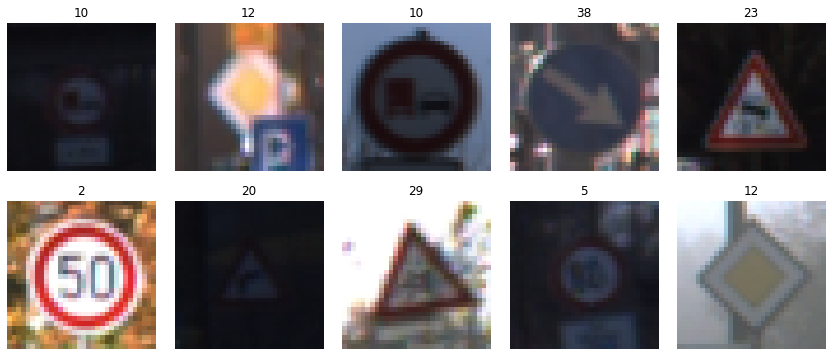

In [26]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

# show image of 10 random data points
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])


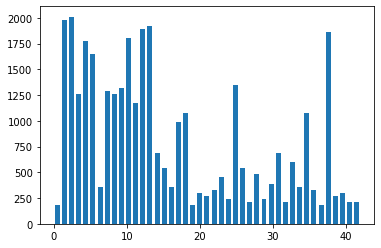

In [27]:
# histogram of label frequency
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [28]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Convert to grayscale
X_train_rgb = X_train
X_train_gry = np.sum(X_train/3, axis=3, keepdims=True)

X_test_rgb = X_test
X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)

print('RGB shape:', X_train_rgb.shape)
print('Grayscale shape:', X_train_gry.shape)

RGB shape: (34799, 32, 32, 3)
Grayscale shape: (34799, 32, 32, 1)


In [30]:
X_train = X_train_gry
X_test = X_test_gry

print('done')

done


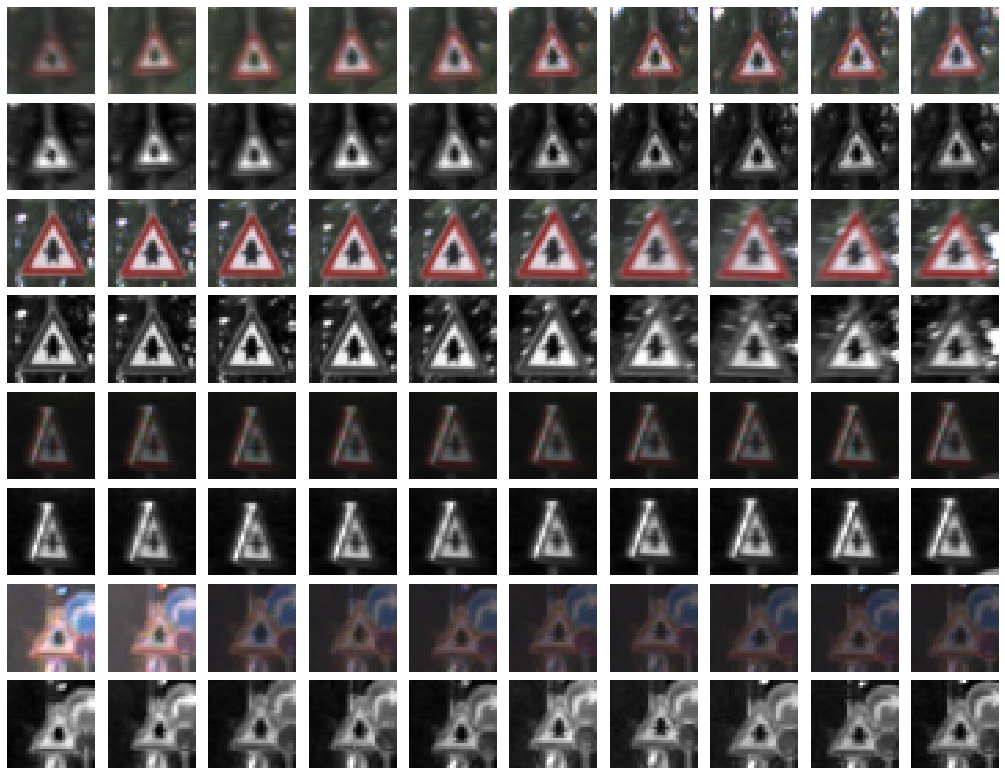

In [31]:
# Visualize rgb vs grayscale
n_rows = 8
n_cols = 10
offset = 9000
fig, axs = plt.subplots(n_rows,n_cols, figsize=(18, 14))
fig.subplots_adjust(hspace = .1, wspace=.001)
axs = axs.ravel()
for j in range(0,n_rows,2):
    for i in range(n_cols):
        index = i + j*n_cols
        image = X_train_rgb[index + offset]
        axs[index].axis('off')
        axs[index].imshow(image)
    for i in range(n_cols):
        index = i + j*n_cols + n_cols 
        image = X_train_gry[index + offset - n_cols].squeeze()
        axs[index].axis('off')
        axs[index].imshow(image, cmap='gray')

In [32]:
print(y_train[0:500])

[41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31

**Jeremy's note**: Obviously this data is going to need to be shuffled.

In [33]:
print(np.mean(X_train))
print(np.mean(X_test))

82.67758903699634
82.14846036120173


In [34]:
## Normalize the train and test datasets to (-1,1)

X_train_normalized = (X_train - 128)/128 
X_test_normalized = (X_test - 128)/128

print(np.mean(X_train_normalized))
print(np.mean(X_test_normalized))

-0.35408133564846583
-0.3582151534281105


Original shape: (34799, 32, 32, 1)
Normalized shape: (34799, 32, 32, 1)


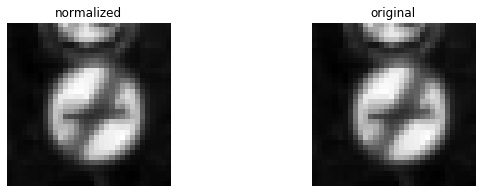

In [35]:
print("Original shape:", X_train.shape)
print("Normalized shape:", X_train_normalized.shape)
fig, axs = plt.subplots(1,2, figsize=(10, 3))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('normalized')
axs[0].imshow(X_train_normalized[0].squeeze(), cmap='gray')

axs[1].axis('off')
axs[1].set_title('original')
axs[1].imshow(X_train[0].squeeze(), cmap='gray')

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** 

My dataset preprocessing consisted of:
 1. Converting to grayscale - This worked well for Sermanet and LeCun as described in their traffic sign classification article. It also helps to reduce training time, which was nice when a GPU wasn't available.
 2. Normalizing the data to the range (-1,1) - This was done using the line of code X_train_normalized = (X_train - 128)/128. The resulting dataset mean wasn't exactly zero, but it was reduced from around 82 to roughly -0.35. I chose to do this mostly because it was suggested in the lessons and it was fairly easy to do. How it helps is a bit nebulous to me, but [this site](http://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn) has an explanation, the gist of which is that having a wider distribution in the data would make it more difficult to train using a singlar learning rate. Different features could encompass far different ranges and a single learning rate might make some weights diverge.

In [36]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

**Jeremy's note**: Four functions for augmenting the dataset: random_translate, random_scale, random_warp, and random_brightness

shape in/out: (32, 32, 1) (32, 32, 1)


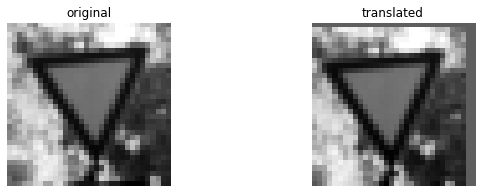

In [37]:
import cv2

def random_translate(img):
    rows,cols,_ = img.shape
    
    # allow translation up to px pixels in x and y directions
    px = 2
    dx,dy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

test_img = X_train_normalized[22222]

test_dst = random_translate(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('translated')

print('shape in/out:', test_img.shape, test_dst.shape)


shape in/out: (32, 32, 1) (32, 32, 1)


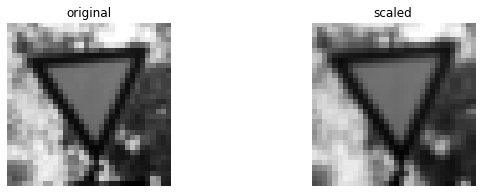

In [38]:
def random_scaling(img):   
    rows,cols,_ = img.shape

    # transform limits
    px = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

test_dst = random_scaling(test_img)
    
fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('scaled')

print('shape in/out:', test_img.shape, test_dst.shape)


shape in/out: (32, 32, 1) (32, 32, 1)


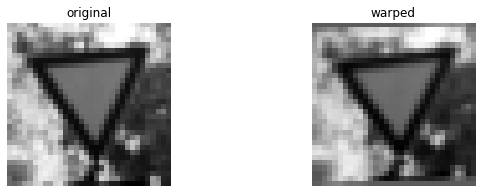

In [39]:
def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

test_dst = random_warp(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('warped')

print('shape in/out:', test_img.shape, test_dst.shape)


shape in/out: (32, 32, 1) (32, 32, 1)


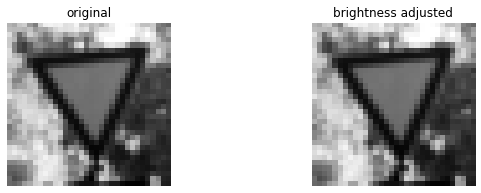

In [40]:
def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst

test_dst = random_brightness(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('brightness adjusted')

print('shape in/out:', test_img.shape, test_dst.shape)


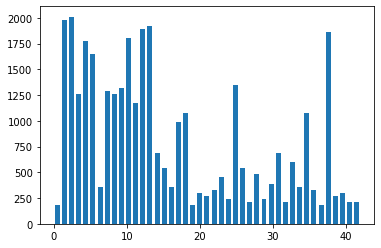

In [41]:
# histogram of label frequency (once again, before data augmentation)
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [42]:
print(np.bincount(y_train))
print("minimum samples for any label:", min(np.bincount(y_train)))

[ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920
  690  540  360  990 1080  180  300  270  330  450  240 1350  540  210
  480  240  390  690  210  599  360 1080  330  180 1860  270  300  210
  210]
minimum samples for any label: 180


In [43]:
print('X, y shapes:', X_train_normalized.shape, y_train.shape)

input_indices = []
output_indices = []

for class_n in range(n_classes):
    print(class_n, ': ', end='')
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    if n_samples < 800:
        for i in range(800 - n_samples):
            input_indices.append(class_indices[0][i%n_samples])
            output_indices.append(X_train_normalized.shape[0])
            new_img = X_train_normalized[class_indices[0][i % n_samples]]
            new_img = random_translate(random_scaling(random_warp(random_brightness(new_img))))
            X_train_normalized = np.concatenate((X_train_normalized, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)
            if i % 50 == 0:
                print('|', end='')
            elif i % 10 == 0:
                print('-',end='')
    print('')
            
print('X, y shapes:', X_train_normalized.shape, y_train.shape)
        

X, y shapes: (34799, 32, 32, 1) (34799,)
0 : |----|----|----|----|----|----|----|----|----|----|----|----|-
1 : 
2 : 
3 : 
4 : 
5 : 
6 : |----|----|----|----|----|----|----|----|---
7 : 
8 : 
9 : 
10 : 
11 : 
12 : 
13 : 
14 : |----|----|
15 : |----|----|----|----|----|
16 : |----|----|----|----|----|----|----|----|---
17 : 
18 : 
19 : |----|----|----|----|----|----|----|----|----|----|----|----|-
20 : |----|----|----|----|----|----|----|----|----|----
21 : |----|----|----|----|----|----|----|----|----|----|--
22 : |----|----|----|----|----|----|----|----|----|-
23 : |----|----|----|----|----|----|----
24 : |----|----|----|----|----|----|----|----|----|----|----|
25 : 
26 : |----|----|----|----|----|
27 : |----|----|----|----|----|----|----|----|----|----|----|---
28 : |----|----|----|----|----|----|-
29 : |----|----|----|----|----|----|----|----|----|----|----|
30 : |----|----|----|----|----|----|----|----|
31 : |----|----|
32 : |----|----|----|----|----|----|----|----|----|----|----|-

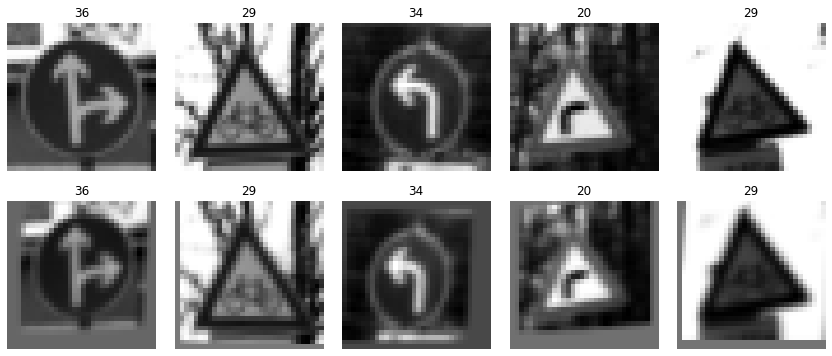

In [44]:
# show comparisons of 5 random augmented data points
choices = list(range(len(input_indices)))
picks = []
for i in range(5):
    rnd_index = np.random.randint(low=0,high=len(choices))
    picks.append(choices.pop(rnd_index))
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(5):
    image = X_train_normalized[input_indices[picks[i]]].squeeze()
    axs[i].axis('off')
    axs[i].imshow(image, cmap = 'gray')
    axs[i].set_title(y_train[input_indices[picks[i]]])
for i in range(5):
    image = X_train_normalized[output_indices[picks[i]]].squeeze()
    axs[i+5].axis('off')
    axs[i+5].imshow(image, cmap = 'gray')
    axs[i+5].set_title(y_train[output_indices[picks[i]]])

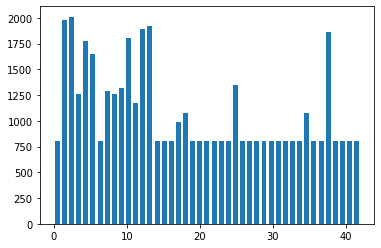

In [45]:
# histogram of label frequency
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [46]:
## Shuffle the training dataset

from sklearn.utils import shuffle

X_train_normalized, y_train = shuffle(X_train_normalized, y_train)

print('done')

done


In [47]:
## Split validation dataset off from training dataset

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train_normalized, y_train, 
                                                                test_size=0.20, random_state=42)

print("Old X_train size:",len(X_train_normalized))
print("New X_train size:",len(X_train))
print("X_validation size:",len(X_validation))

Old X_train size: 46480
New X_train size: 37184
X_validation size: 9296


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** 

Rumor has it that data augmentation is the single best method to increase accuracy of the model. Because several classes in the data have far fewer samples than others the model will tend to be biased toward those classes with more samples. I implemented augmentation by creating copies of each sample for a class (sometimes several copies) in order to boost the number of samples for the class to 800 (if that class didn't already have at least 800 samples). Each copy is fed into a "jitter" pipeline that randomly translates, scales, warps, and brightness adjusts the image. I sought to keep the parameters for these transformations relatively conservative and keep the sign in the image recognizable. This was by far the most laborious part of the project, and it takes quite some time to run the code.

I also used the SciKit Learn train_test_split function to create a validation set out of the training set. I used 20% of the testing set to create the validation set.

In [48]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [49]:
import tensorflow as tf

EPOCHS = 60
BATCH_SIZE = 100

print('done')

done


## Original LeNet Model Architecture

![LeNet](https://github.com/jeremy-shannon/CarND-LeNet-Lab/raw/cd4ba97906176e6020a4b3c084b7518ef3dded5e/lenet.png)

In [50]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6))
    x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())

    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16))
    x = tf.nn.bias_add(x, b2)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    x = flatten(x)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    W3 = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    b3 = tf.Variable(tf.zeros(120))    
    x = tf.add(tf.matmul(x, W3), b3)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    W4 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    b4 = tf.Variable(tf.zeros(84)) 
    x = tf.add(tf.matmul(x, W4), b4)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    W5 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    b5 = tf.Variable(tf.zeros(43)) 
    logits = tf.add(tf.matmul(x, W5), b5)
    
    return logits

print('done')

done


## Modified LeNet Model Architecture
*adapted from Sermanet/LeCunn traffic sign classification journal article*

![Modified LeNet](/files/images/modifiedLeNet.jpeg)

In [51]:
from tensorflow.contrib.layers import flatten

def LeNet2(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="W1")
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6), name="b1")
    x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())

    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="W2")
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16), name="b2")
    x = tf.nn.bias_add(x, b2)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer2 = x
    
    # TODO: Layer 3: Convolutional. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="W3")
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(400), name="b3")
    x = tf.nn.bias_add(x, b3)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)
    layer3 = x

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    layer2flat = flatten(layer2)
    print("layer2flat shape:",layer2flat.get_shape())
    
    # Flatten x. Input = 1x1x400. Output = 400.
    xflat = flatten(x)
    print("xflat shape:",xflat.get_shape())
    
    # Concat layer2flat and x. Input = 400 + 400. Output = 800
    x = tf.concat_v2([xflat, layer2flat], 1)
    print("x shape:",x.get_shape())
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    # TODO: Layer 4: Fully Connected. Input = 800. Output = 43.
    W4 = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma), name="W4")
    b4 = tf.Variable(tf.zeros(43), name="b4")    
    logits = tf.add(tf.matmul(x, W4), b4)
    
    # TODO: Activation.
    #x = tf.nn.relu(x)

    # TODO: Layer 5: Fully Connected. Input = 120. Output = 84.
    #W5 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    #b5 = tf.Variable(tf.zeros(84)) 
    #x = tf.add(tf.matmul(x, W5), b5)
    
    # TODO: Activation.
    #x = tf.nn.relu(x)

    # TODO: Layer 6: Fully Connected. Input = 84. Output = 43.
    #W6 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    #b6 = tf.Variable(tf.zeros(43)) 
    #logits = tf.add(tf.matmul(x, W6), b6)
    
    return logits

print('done')

done


In [52]:
tf.reset_default_graph() 

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
one_hot_y = tf.one_hot(y, 43)

print('done')

done


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I began by implementing the same architecture from the LeNet Lab, with no changes since my dataset is in grayscale. This model worked quite well to begin with (~96% validation accuracy), but I also implemented the Sermanet/LeCun model from their traffic sign classifier paper and saw an immediate improvement. Although the paper doesn't go into detail describing exactly how the model is implemented (particularly the depth of the layers) I was able to make it work. The layers are set up like this:
1. 5x5 convolution (32x32x1 in, 28x28x6 out)
2. ReLU
3. 2x2 max pool (28x28x6 in, 14x14x6 out)
4. 5x5 convolution (14x14x6 in, 10x10x16 out)
5. ReLU
6. 2x2 max pool (10x10x16 in, 5x5x16 out)
7. 5x5 convolution (5x5x6 in, 1x1x400 out)
8. ReLu
9. Flatten layers from numbers 8 (1x1x400 -> 400) and 6 (5x5x16 -> 400)
10. Concatenate flattened layers to a single size-800 layer
11. Dropout layer
12. Fully connected layer (800 in, 43 out)

In [53]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [54]:
rate = 0.0009

logits = LeNet2(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

layer 1 shape: (?, 28, 28, 6)
layer2flat shape: (?, 400)
xflat shape: (?, 400)


AttributeError: module 'tensorflow' has no attribute 'concat_v2'

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print('done')

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

# Log
- 2016/01/03 - 96.5% 
    - preprocessing: grayscale, normalization
    - model: original LeNet, batch size: 128, epochs: 10, rate: 0.001, mu: 0, sigma: 0.1
- 2016/01/04 - 97.5%
    - model: modified LeNet
        - additional convolution layer (no max pool) flattened and concatenated with flattened layer 2 output
        - i.e. 5x5x16 branched off to 5x5 convolution (output of 1x1x400), each flattened (to 400) and concatenated (800)
    - all other layers the same, except first fully connected to accommodate change from 400 to 800
    - all other hyperparameters and preprocessing the same
- 2016/01/04 - 98.3%
    - model: further modified LeNet
        - removed last two fully connected layers so that the lone fully connected layer acts as classifier (800 -> 43)
    - all other hyperparameters and preprocessing the same
- 2016/01/04 - 97.5%
    - reduced learning rate 50% (to 0.0005) after observing some bounce in accuracy across epochs
- 2016/01/05 - 98.6%
    - changed learning rate to 0.0008, nothing more
- 2016/01/08 - after a few days of implementing data augmentation (and one day off in there) I'm having trouble improving or even getting close to my previous validation accuracy. I first tried augmenting all labels up to the point of 1500 samples (which takes a very long time, even on GPU - now working), but it seems to have crippled my validation accuracy to ~70% (where-about it starts and ends across all epochs). Obviously I'm doing something wrong in my data augmentation, so that's where I am right now.
- 2016/01/08 - squashed the bug in the augmentation code and got accuracy back to high 90's, then implemented dropout and (after some difficulty) achieved similar accuracy (~97%)
- 2016/01/08 - 98.3%
    - after the changes above, adjusted the keep_prob from 0.5 to 0.75
    - still LeNet2, batch size: 128, epochs: 10, rate: 0.001, mu: 0, sigma: 0.1
- 2016/01/08 - 92.8%
    - model: LeNet2, batch size: 256, epochs: 15, rate: 0.00075, mu: 0, sigma: 0.3
- 2016/01/08 - 98.2%
    - model: LeNet2, batch size: 256, epochs: 15, rate: 0.00075, mu: 0, sigma: 0.1
- 2016/01/08 - 97.7%
    - model: LeNet2, batch size: 256, epochs: 15, rate: 0.00075, mu: 0, sigma: 0.05
- 2016/01/08 - 93.4%
    - model: LeNet2, batch size: 512, epochs: 15, rate: 0.00075, mu: 0, sigma: 0.1
- 2016/01/08 - 95.3%
    - model: LeNet2, batch size: 512, epochs: 25, rate: 0.00075, mu: 0, sigma: 0.1
- 2016/01/08 - 97.7%
    - model: LeNet2, batch size: 64, epochs: 25, rate: 0.00075, mu: 0, sigma: 0.1
- 2016/01/08 - 97.9%
    - model: LeNet2, batch size: 64, epochs: 25, rate: 0.001, mu: 0, sigma: 0.1
- 2016/01/08 - 98.2%
    - model: LeNet2, batch size: 100, epochs: 25, rate: 0.001, mu: 0, sigma: 0.1
- 2016/01/08 - 98.5%
    - model: LeNet2, batch size: 100, epochs: 100, rate: 0.001, mu: 0, sigma: 0.1
    - leveled off around epoch 50
- 2016/01/08 - 98.8%
    - model: LeNet2, batch size: 100, epochs: 100, rate: 0.0009, mu: 0, sigma: 0.1
- 2016/01/08 - 98.7%
    - model: LeNet2, batch size: 100, epochs: 100, rate: 0.0008, mu: 0, sigma: 0.1
- 2016/01/08 - 98.7%
    - model: LeNet2, batch size: 100, epochs: 100, rate: 0.0005, mu: 0, sigma: 0.1
- 2016/01/08 - 97.7%
    - model: LeNet2, batch size: 100, epochs: 100, rate: 0.0001, mu: 0, sigma: 0.1
- 2016/01/08 - 99.0%
    - model: LeNet2, batch size: 100, epochs: 100, rate: 0.0009, mu: 0, sigma: 0.1, keep_prob: 0.6
- 2016/01/08 - 99.0%
    - model: LeNet2, batch size: 100, epochs: 100, rate: 0.0009, mu: 0, sigma: 0.1, keep_prob: 0.55
- 2016/01/08 - 99.0%
    - model: LeNet2, batch size: 100, epochs: 100, rate: 0.0009, mu: 0, sigma: 0.1, keep_prob: 0.5
- 2016/01/08 - 98.9%
    - model: LeNet2, batch size: 100, epochs: 60, rate: 0.0009, mu: 0, sigma: 0.1, keep_prob: 0.5
- 2016/01/08 - 99.1%
    - model: LeNet2, batch size: 100, epochs: 60, rate: 0.0009, mu: 0, sigma: 0.1, keep_prob: 0.5
- 2016/01/16 - 99.3%
    - model: LeNet2, batch size: 100, epochs: 60, rate: 0.0009, mu: 0, sigma: 0.1, keep_prob: 0.5

In [ ]:
# Now (drumroll) evaluate the accuracy of the model on the test dataset

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver2.restore(sess, "./lenet")
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

### Hooray! 94.7% accuracy!

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used the Adam optimizer (already implemented in the LeNet lab). The final settings used were:
- batch size: 100
- epochs: 60
- learning rate: 0.0009
- mu: 0
- sigma: 0.1
- dropout keep probability: 0.5

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

My approach was a little of both. Like I mentioned earlier, I started with pre-defined architectures (LeNet and the Sermanet/LeCun model) and almost all of the tweaking from there was a process of trial and error. Thankfully, my guesses were educated thanks to working through the Tensorflow and LeNet labs. I had also worked through the exercises for the Udacity Deep Learning course, and it was at that time that I discovered that trial and error is pretty much a losing strategy when it comes to building the neural net. I kept a log of my experiments, above, that shows how I played with hyperparameters to get a good level of validation accuracy.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
# Reinitialize and re-import if starting a new kernel here
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np
import cv2

print('done')

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

#reading in an image
import glob
import matplotlib.image as mpimg

fig, axs = plt.subplots(2,4, figsize=(4, 2))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

my_images = []

for i, img in enumerate(glob.glob('./my-found-traffic-signs/*x.png')):
    image = cv2.imread(img)
    axs[i].axis('off')
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    my_images.append(image)

my_images = np.asarray(my_images)

my_images_gry = np.sum(my_images/3, axis=3, keepdims=True)

my_images_normalized = (my_images_gry - 128)/128 

print(my_images_normalized.shape)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** 

Nothing in particular sticks out that I think would make classification difficult. My images appear to be more easily distinguishable than quite a few images from the original dataset. I noticed that my images tend to be quite a bit brighter and might occupy a different range in the color space, possibly a range that the model was not trained on. In addition, the GTSRB dataset states that the images "contain a border of 10 % around the actual traffic sign (at least 5 pixels) to allow for edge-based approaches" and the images that I used do not all include such a border. This could be another source of confusion for the model.

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

my_labels = [3, 11, 1, 12, 38, 34, 18, 25]


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./lenet.meta')
    saver3.restore(sess, "./lenet")
    my_accuracy = evaluate(my_images_normalized, my_labels)
    print("Test Set Accuracy = {:.3f}".format(my_accuracy))

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The model appears to have predicted the new signs perfectly, with 100% accuracy - even better than the 99.3% validation accuracy and the 94.7% test accuracy. This is a good sign that the model performs well on real-world data. And while it's reasonable to assume that the accuracy would not remain so high given more data points, judging by the low fidelity of a number of images in the training dataset it's also reasonable to assume that if the real-world data were all as easily distinguishable as the eight images chosen that the accuracy would remain very high.

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: my_images_normalized, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: my_images_normalized, keep_prob: 1.0})

    
    fig, axs = plt.subplots(len(my_images),4, figsize=(12, 14))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(my_images):
        axs[4*i].axis('off')
        axs[4*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[4*i].set_title('input')
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_validation == guess1)[0]
        axs[4*i+1].axis('off')
        axs[4*i+1].imshow(X_validation[index1].squeeze(), cmap='gray')
        axs[4*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*my_top_k[0][i][0]))
        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(y_validation == guess2)[0]
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(X_validation[index2].squeeze(), cmap='gray')
        axs[4*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*my_top_k[0][i][1]))
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(y_validation == guess3)[0]
        axs[4*i+3].axis('off')
        axs[4*i+3].imshow(X_validation[index3].squeeze(), cmap='gray')
        axs[4*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*my_top_k[0][i][2]))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
fig, axs = plt.subplots(8,2, figsize=(9, 19))
axs = axs.ravel()

for i in range(len(my_softmax_logits)*2):
    if i%2 == 0:
        axs[i].axis('off')
        axs[i].imshow(cv2.cvtColor(my_images[i//2], cv2.COLOR_BGR2RGB))
    else:
        axs[i].bar(np.arange(n_classes), my_softmax_logits[(i-1)//2]) 
        axs[i].set_ylabel('Softmax probability')
    

**Answer:**

The model is somehow ONE HUNDRED PERCENT certain of 7 out of 8 of the signs I gave it (and it's correct: as you can see further above, I pulled an image for each of the top 3 predicted classes from the original dataset for comparison). Even on the third image, it's 92% certain of its prediction. This very high level of certainty, along with achieving 100% accuracy, on the newly introduced real-world data is indicative of a model that performs very well.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

## (a couple of utilities for saving and loading augmented and split datasets)

In [ ]:
aug_train = {'features': X_train,
             'labels': y_train}
aug_val = {'features': X_validation,
             'labels': y_validation}
aug_test = {'features': X_test_normalized,
             'labels': y_test}
pickle.dump(aug_train, open( "./my-augmented-data/aug_train.p", "wb" ) )
pickle.dump(aug_val, open( "./my-augmented-data/aug_val.p", "wb" ) )
pickle.dump(aug_test, open( "./my-augmented-data/aug_test.p", "wb" ) )

print('done')

In [ ]:
# Load pickled data
import pickle

training_file = "./my-augmented-data/aug_train.p"
validation_file = "./my-augmented-data/aug_val.p"
testing_file = "./my-augmented-data/aug_test.p"

with open(training_file, mode='rb') as f:
    aug_train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    aug_val = pickle.load(f)
with open(testing_file, mode='rb') as f:
    aug_test = pickle.load(f)
    
X_train, y_train = aug_train['features'], aug_train['labels']
X_validation, y_validation = aug_val['features'], aug_val['labels']
X_test_normalized, y_test = aug_test['features'], aug_test['labels']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_validation shape:", X_validation.shape)
print("y_validation shape:", y_validation.shape)
print("X_test shape:", X_test_normalized.shape)
print("y_test shape:", y_test.shape)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_validation shape:", X_validation.shape)
print("y_validation shape:", y_validation.shape)
print("X_test shape:", X_test_normalized.shape)
print("y_test shape:", y_test.shape)